# Getting the data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
plt.style.use("seaborn-v0_8")
warnings.filterwarnings("ignore")

In [10]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")

In [11]:
data

,Close,Volume
Date,,
2017-08-17 04:00:00,4308.83,47.181009
2017-08-17 05:00:00,4315.32,23.234916
2017-08-17 06:00:00,4324.35,7.229691
2017-08-17 07:00:00,4349.99,4.443249
2017-08-17 08:00:00,4360.69,0.972807
...,...,...
2021-10-07 05:00:00,54735.76,2251.122020
2021-10-07 06:00:00,54534.16,1783.004260
2021-10-07 07:00:00,54755.92,4163.431360


In [13]:
data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))

In [14]:
data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
data.loc[data.vol_ch < -3, "vol_ch"] = np.nan

In [15]:
data

,Close,Volume,returns,vol_ch
Date,,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505,-0.708335
2017-08-17 06:00:00,4324.35,7.229691,0.002090,-1.167460
2017-08-17 07:00:00,4349.99,4.443249,0.005912,-0.486810
2017-08-17 08:00:00,4360.69,0.972807,0.002457,-1.518955
...,...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146,0.439863
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690,-0.233129
2021-10-07 07:00:00,54755.92,4163.431360,0.004058,0.848040


In [17]:
data["position"] = 0
data

,Close,Volume,returns,vol_ch,position
Date,,,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN,NaN,0
2017-08-17 05:00:00,4315.32,23.234916,0.001505,-0.708335,0
2017-08-17 06:00:00,4324.35,7.229691,0.002090,-1.167460,0
2017-08-17 07:00:00,4349.99,4.443249,0.005912,-0.486810,0
2017-08-17 08:00:00,4360.69,0.972807,0.002457,-1.518955,0
...,...,...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146,0.439863,0
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690,-0.233129,0
2021-10-07 07:00:00,54755.92,4163.431360,0.004058,0.848040,0


##### Buy and go Long(position = 1) if most recent returns are highly negative(cond1) and trading volume decreased(cond2)

In [18]:
return_thresh = np.percentile(data.returns.dropna(), 10)
return_thresh

-0.007813258140358005

In [19]:
cond1 = data.returns <= return_thresh
cond1

Date
2017-08-17 04:00:00    False
2017-08-17 05:00:00    False
2017-08-17 06:00:00    False
2017-08-17 07:00:00    False
2017-08-17 08:00:00    False
                       ...  
2021-10-07 05:00:00    False
2021-10-07 06:00:00    False
2021-10-07 07:00:00    False
2021-10-07 08:00:00    False
2021-10-07 09:00:00     True
Name: returns, Length: 36168, dtype: bool

In [20]:
volume_thresh = np.percentile(data.vol_ch.dropna(), [5, 20])
volume_thresh

array([-0.72895253, -0.37604441])

In [21]:
cond2 = data.vol_ch.between(volume_thresh[0], volume_thresh[1])
cond2

Date
2017-08-17 04:00:00    False
2017-08-17 05:00:00     True
2017-08-17 06:00:00    False
2017-08-17 07:00:00     True
2017-08-17 08:00:00    False
                       ...  
2021-10-07 05:00:00    False
2021-10-07 06:00:00    False
2021-10-07 07:00:00    False
2021-10-07 08:00:00     True
2021-10-07 09:00:00    False
Name: vol_ch, Length: 36168, dtype: bool

In [22]:
data.loc[cond1 & cond2, "position"] = 1

##### Sell and go Short (position = -1) if most recent returns are highly positive(cond3) and trading volume decreased(cond2)

In [28]:
# getting returns threshold for highly negative returns(>= 90th percentile)
# 상위10% 수익률을 말하는 임계값
return_thresh = np.percentile(data.returns.dropna(), 90)
return_thresh

0.008231867023808183

In [29]:
cond3 = data.returns >= return_thresh
cond3

Date
2017-08-17 04:00:00    False
2017-08-17 05:00:00    False
2017-08-17 06:00:00    False
2017-08-17 07:00:00    False
2017-08-17 08:00:00    False
                       ...  
2021-10-07 05:00:00    False
2021-10-07 06:00:00    False
2021-10-07 07:00:00    False
2021-10-07 08:00:00    False
2021-10-07 09:00:00    False
Name: returns, Length: 36168, dtype: bool

In [30]:
data.loc[cond3 & cond2, "position"] = -1

In [31]:
data.position.value_counts()

position
 0    35526
-1      364
 1      278
Name: count, dtype: int64

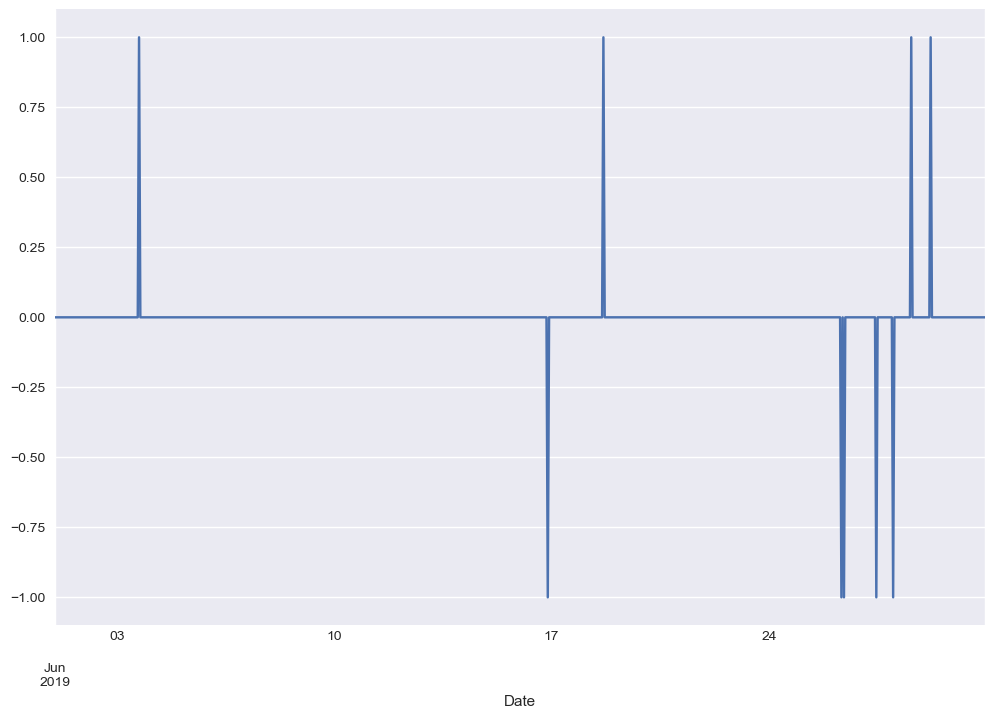

In [32]:
data.loc["06-2019", "position"].plot(figsize = (12, 8))
plt.show()